## 1. Import packages

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Load data

In [2]:
df = pd.read_csv("data_for_predictions.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,71,9,1,0,0,0,0,1,0,0


In [3]:
from sklearn import metrics
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier

### Data sampling

In [4]:
train_df = df.copy()

y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 61)
(14606,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 61)
(10954,)
(3652, 61)
(3652,)


## 3. Finding Hyperparameters

In [6]:
cv_scores = []
n_estimators_range = range(1, 101, 20)

In [7]:
for i in n_estimators_range:
    model = RandomForestClassifier(n_estimators=i, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_scores.append(scores.mean())

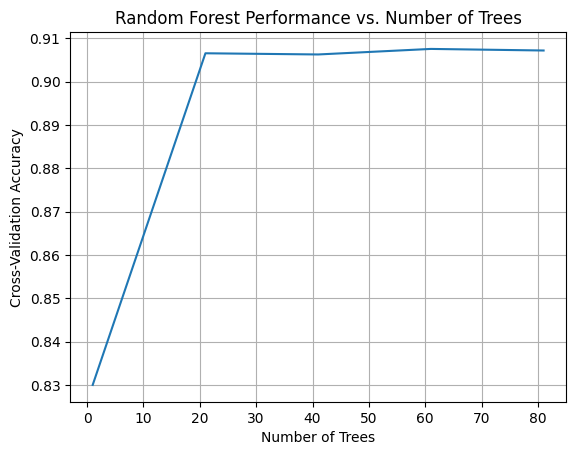

In [11]:
plt.plot(n_estimators_range, cv_scores)
plt.xlabel('Number of Trees')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Random Forest Performance vs. Number of Trees')
plt.grid(True)

## 4. Model training

In [26]:
model = RandomForestClassifier(n_estimators=22, random_state=42)
model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=22, random_state=42)

In [27]:
y_preds=model.predict(X_test)

## 5. Evaluation

In [28]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test,y_preds))
accuracy = accuracy_score(y_test, y_preds)*100
print(f'Accuracy Score: {accuracy:.2f}')

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3286
           1       0.69      0.06      0.11       366

    accuracy                           0.90      3652
   macro avg       0.80      0.53      0.53      3652
weighted avg       0.88      0.90      0.86      3652

Accuracy Score: 90.31


## Model understanding

In [29]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

Text(0.5, 0, 'Importance')

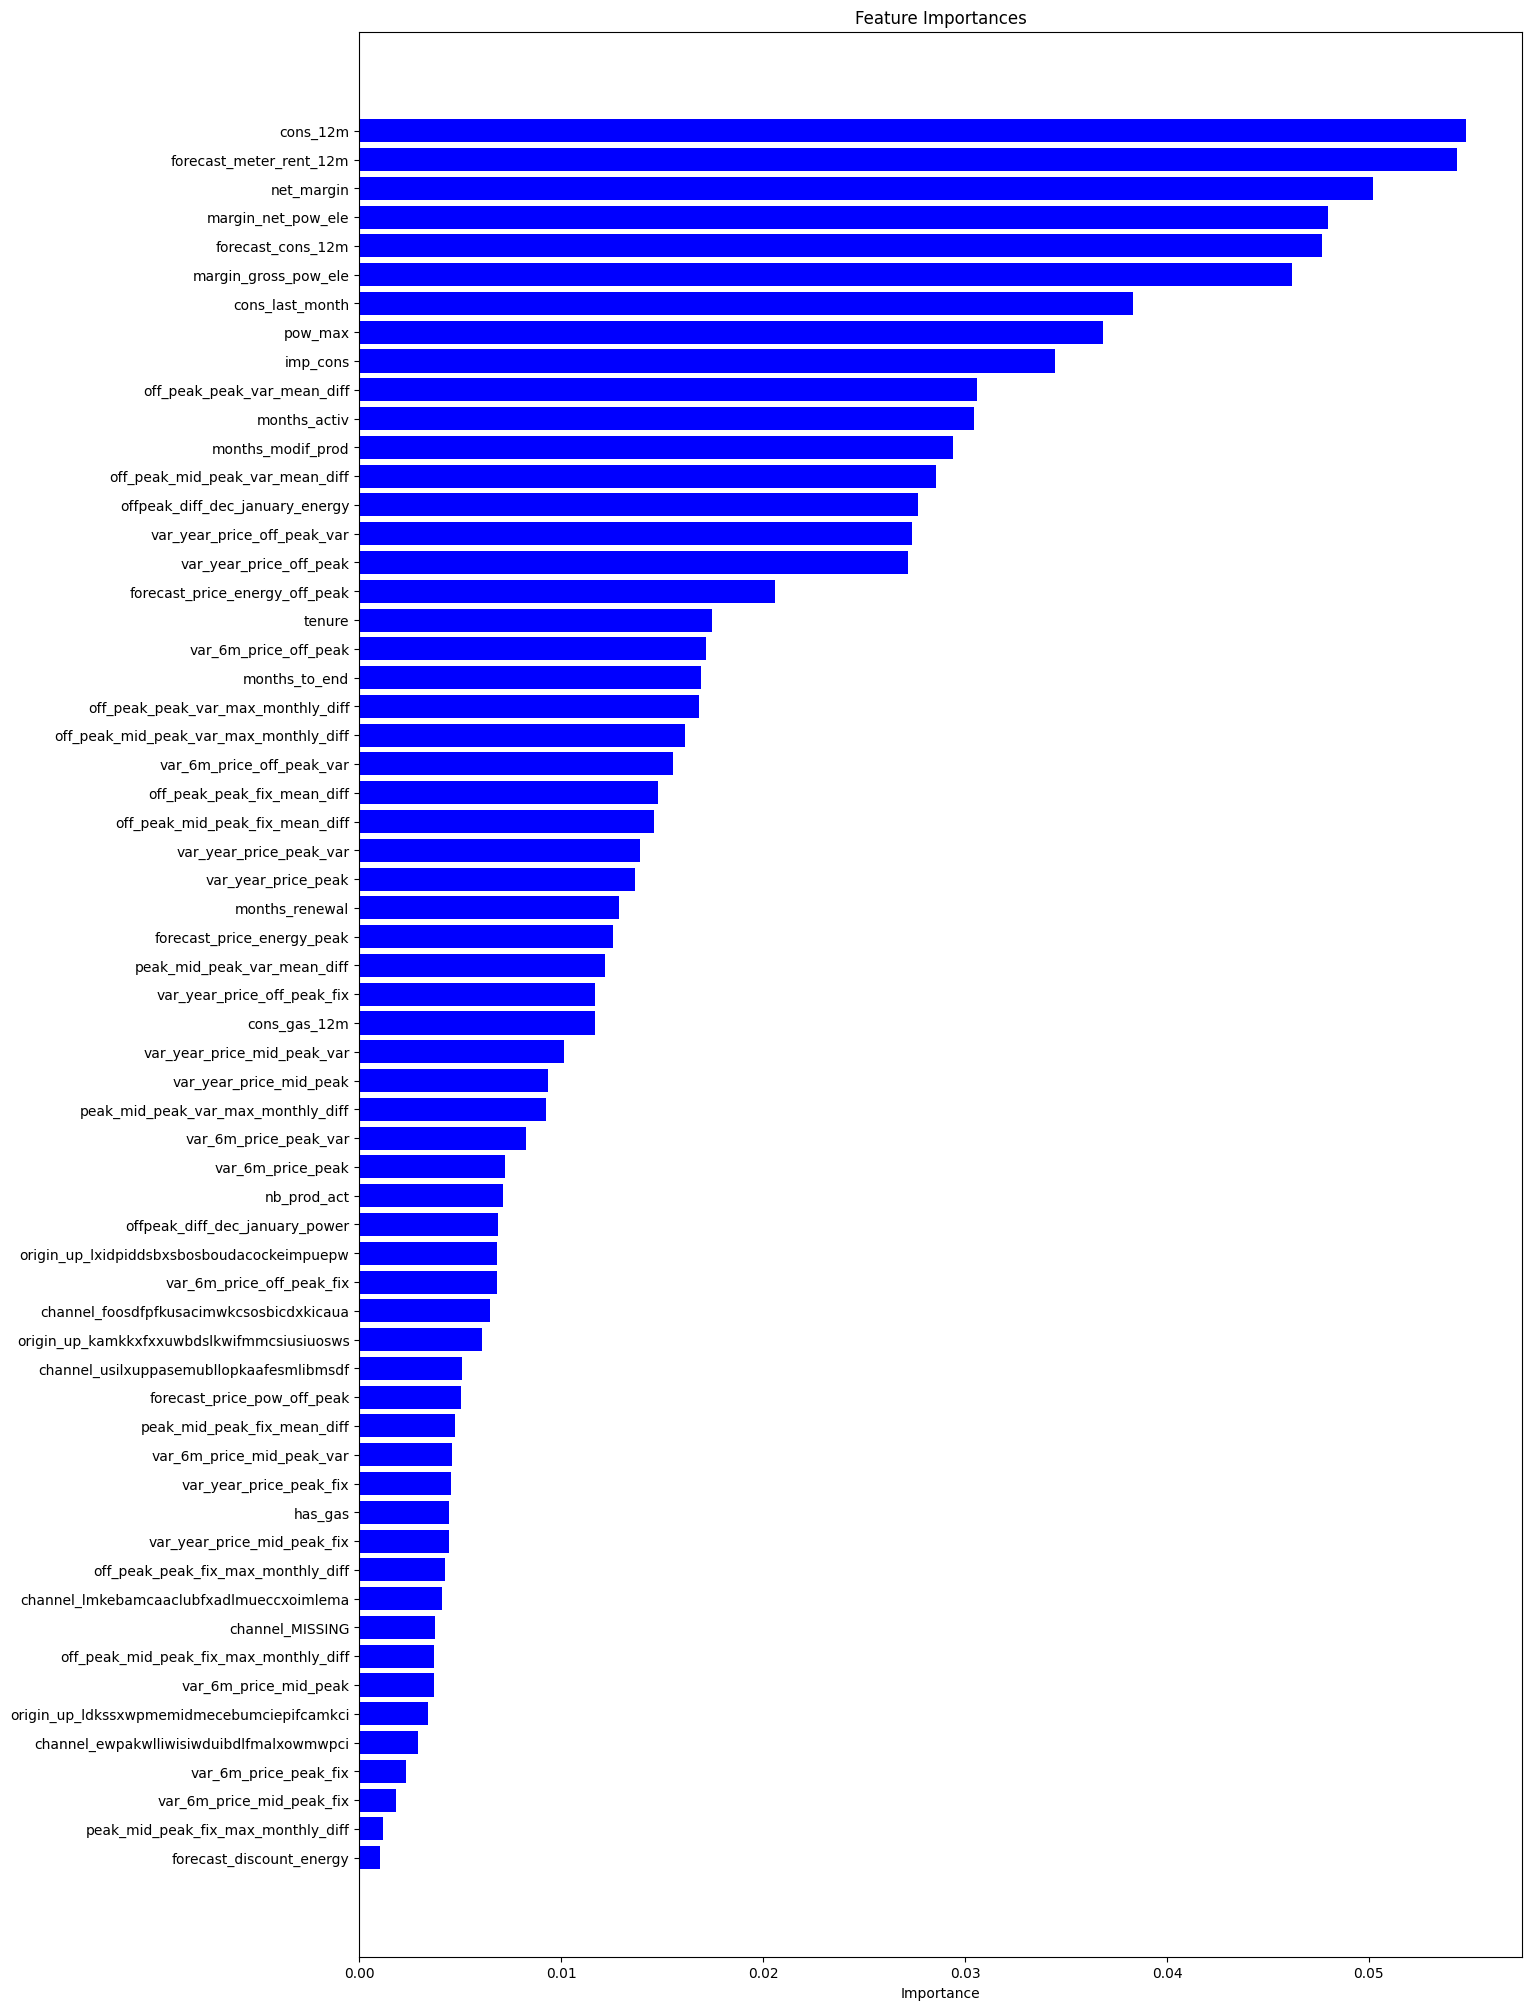

In [31]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')

In [32]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]

In [33]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [35]:
X_test['churn'] = y_preds.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('out_of_sample_data_with_predictions.csv')